In [1]:
%load_ext dotenv 
%dotenv
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from statsmodels.stats.weightstats import ttost_ind
from math import ceil
import sqlalchemy as sa
from tqdm import tqdm
import statsmodels.stats.api as sms
import statsmodels.api as sm
from sklearn.neighbors import NearestNeighbors
from datetime import datetime, timedelta
from data.connectors import read_sql_query

In [3]:
## DATA QUERIES

def get_checks_query(date_from, date_to):
    # запрос который считает сумму по заказу
    return f"""
select 
        shipped_at,
        store_id,
        gmv_advertising + gmv_service_fee_net_promo + gmv_goods_net_promo as check
from analytics.financial_measures
where (shipped_at between toDate('{date_from}') and toDate('{date_to}')) and tenant_id = 'sbermarket' and shipment_state='shipped'
"""

def get_check_canceled_query(date_from, date_to):
    return f"""select  
            starts_at,
            shipment_id,
            store_id,
            gmv_advertising + gmv_service_fee_net_promo + gmv_goods_net_promo as check_cancelled -- или просто item_total?
    from analytics.financial_measures
    where (starts_at between toDate('{date_from}') and toDate('{date_to}')) and tenant_id = 'sbermarket' and shipment_state='canceled'"""

def get_gmv_per_user_query(date_from, date_to):
    return f"""
select 
        uuid,
        store_id,
        sum(gmv_advertising) + sum(gmv_service_fee_net_promo) + sum(gmv_goods_net_promo) as gmv_net_of_promo
from analytics.financial_measures
where (shipped_at between toDate('{date_from}') and toDate('{date_to}')) and tenant_id = 'sbermarket'
group by dictGet('analytics.spree_users_dict', 'uuid', toUInt64(user_id)) as uuid, store_id
"""

# запрос для подсчета отмен/замен
def get_not_found_query(date_from, date_to):
    return f"""
    select 
    ss.shipped_at as shipped_at_utc,
    ss.store_id,
    CASE 
     WHEN lir.from_item_id is null and  lic.line_item_id is null
     THEN 0
     ELSE 1
    END not_found,
    CASE
    WHEN lic.line_item_id is not null
    THEN 1
    ELSE 0
    END cancellations,
    CASE 
     WHEN lir_replace.to_item_id = sli.id
     THEN 1
     ELSE 0
    END is_replacement

    from spree_line_items as sli
    join spree_shipments as ss on sli.shipment_id = ss.id
    JOIN spree_orders as o on ss.order_id = o.id
    JOIN device_attributions as da on o.id = da.order_id
    join store_configs as sc on ss.store_id = sc.store_id
    left join line_item_cancellations as lic on sli.id = lic.line_item_id
    left join line_item_replacements as lir on sli.id = lir.from_item_id
    left join line_item_replacements as lir_replace on sli.id = lir_replace.to_item_id

    where ss.state = 'shipped' and 
    (ss.shipped_at >= date('{date_from}') and ss.shipped_at < date('{date_to}')) and
     not (sli.deleted_at is not null and lic.line_item_id is null and lir.from_item_id is null)
     and (client_identifier is null or client_identifier in ('InstamartApp', 'SbermarketAndroid', 'SbermarketIOS'))
"""

def get_collection_time_query(date_from, date_to):
    return f"""
           select shipped_at, store_id, items_collection_time as time 
           from sandbox.cte_decomposition_new
           where shipped_at between toDate('{date_from}') and toDate('{date_to}')
           """

# запрос оценки за заказ
def get_rate_query(date_from, date_to):
    return f"""
    SELECT  shipped_at, store_id, rate
      FROM  spree_shipments
      JOIN shipment_reviews on shipment_reviews.shipment_id = spree_shipments.id
      WHERE  shipment_reviews.rate is not null
    AND  spree_shipments.shipped_at BETWEEN  date('{date_from}') and date('{date_to}')
    """

# конверсия в заказ по новому приложению
def get_conversion_to_order(date_from, date_to):
    return f"""
select distinct
    anonymous_id,
    context_traits_store_id as store_id,
    case
    when complete_page.anonymous_id is null then 0 else 1
    end as conversion
from new_app.main_page_viewed as main_page
global left join (
    select distinct 
    anonymous_id,
    context_traits_store_id
    from new_app.order_completed
    where timestamp between toDate('{date_from}') and toDate('{date_to}')
) as complete_page on (main_page.anonymous_id = complete_page.anonymous_id) and (main_page.context_traits_store_id = complete_page.context_traits_store_id)
where  main_page.context_traits_store_id is not null and (main_page.timestamp between toDate('{date_from}') and toDate('{date_to}'))
"""

def splitted_get_not_found_query(date_from, date_to):
    start_date = datetime.strptime(date_from, "%Y-%m-%d")
    end_date = datetime.strptime(date_to, "%Y-%m-%d")
    delta = end_date - start_date
    nf_data = []
    for i in tqdm(range(delta.days)):
        p_date_from = (start_date + timedelta(days=i)).strftime("%Y-%m-%d")
        p_date_to = (start_date + timedelta(days=i+1)).strftime("%Y-%m-%d")
        nf_data.append(read_sql_query(get_not_found_query(p_date_from, p_date_to), con="mysql"))
    return pd.concat(nf_data)

## CUSTOM ECONOMETRICS

### Stratified split

In [4]:
def bucketization(df, num_metrics, n_bins):
    data = df.copy()
    bin_metrics = []
    for metric in num_metrics:
        data[metric + "_bin"] = pd.cut(data[metric].values, bins=n_bins)
        bin_metrics.append(metric + "_bin")
    return data, bin_metrics

def clusterization(df, bin_metrics, cat_metrics):
    data = df.copy()
    cluster_metrics = bin_metrics + cat_metrics
    all_clusters = data[cluster_metrics].drop_duplicates().copy()
    all_clusters["num_cluster"] = range(all_clusters.shape[0])
    data = data.merge(all_clusters, on=cluster_metrics)
    return data

def get_stratified_splits(df, id_column, cluster_column="num_cluster", n_splits=50, group_size=100):

    final_split = {i:{'control' : {},'test' : {}} for i in range(n_splits)}
    for split in tqdm(range(n_splits)):
        data = df.sample(n=2*group_size, replace=False).copy()
        cluster_names = data[cluster_column].unique()
        test_group_samples = []
        control_group_samples = []
        for cluster in cluster_names:
            cluster_samples = data[data[cluster_column]==cluster]
            size = cluster_samples.shape[0]//2
            if size == 0:
                size = np.random.choice([0,1])

            test_samples = np.random.choice(cluster_samples[id_column].values, size=size, replace=False)
            test_group_samples.extend(test_samples)
            control_group_samples.extend(cluster_samples[~cluster_samples[id_column].isin(test_samples)][id_column].tolist())
        final_split[split]['control'][id_column] = np.array(control_group_samples)
        final_split[split]['test'][id_column] = np.array(test_group_samples)
    return final_split

### Distance minimization split

In [5]:
def split_cost(data, metric = 'gmv', bootstraps = 1000, size=500, date_col="shipped_at"): 
    df = data.copy()
    stores = df.store_id.unique()
    costs = []
    group_treatment = []
    group_control = []
    
    for i in range(bootstraps): 
        df['group'] = 'control'
        test = np.random.choice(df.store_id.unique(), size = size, replace = False)
        control = np.random.choice(df[~df.store_id.isin(test)].store_id.unique(), size = size, replace = False)
        group_treatment.append(test)
        group_control.append(control)
        
        costs.append(np.linalg.norm(df[df.store_id.isin(test)].groupby(date_col).sum().reset_index()[metric] - df[df.store_id.isin(control)].groupby(date_col).sum().reset_index()[metric]))
    
    print(len(group_treatment), len(group_control))
    
    mins = np.array(costs).argmin()
    print(mins)
    test = group_treatment[mins]
    control = group_control[mins]
    
    return test, control

def get_minimized_splits(data, metric, bootstraps=1000, groupsize=500, date_col="shipped_at", n_splits=1000):
    
    final_split = {i:{'control' : {},'test' : {}} for i in range(n_splits)}
    for split in tqdm(range(n_splits)):
        test_group_samples, control_group_samples = split_cost(data=data, metric=metric, 
                                                               bootstraps=bootstraps, size=groupsize, 
                                                               date_col=date_col)
        final_split[split]['control']["store_id"] = np.array(control_group_samples)
        final_split[split]['test']["store_id"] = np.array(test_group_samples)
    return final_split
        

### Tests

In [6]:
def simple_test_smart_cov_cuped(data_pre, data_post, metric, test, control, synth=False, effect_mean=None, effect_std=None, aa_eff=False):
    tmp = data_post[data_post.store_id.isin(np.concatenate((control, test)))].copy()    
    tmp.loc[tmp.store_id.isin(control), 'treatment'] = 0
    tmp.loc[tmp.store_id.isin(test), 'treatment'] = 1
    if synth:
        tmp.loc[tmp.store_id.isin(test), 'treatment'] = 1
        tmp.loc[tmp.store_id.isin(test), metric] = tmp.loc[tmp.store_id.isin(test), metric] + np.random.normal(loc=effect_mean, scale=effect_std, size=tmp.store_id.isin(test).sum())
    
    cuped_data = data_pre.groupby("store_id").agg({metric: "mean"}).reset_index().rename({metric: "CUPED_X"}, axis=1)
    tmp = tmp.merge(cuped_data, on="store_id")
    
    ### посчитаем y_hat из cuped и y_cuped
    y_control = tmp.query("treatment==0")[metric]
    X_cov_control = tmp.query("treatment==0").drop([metric, "treatment", "date"], axis=1)
    y_hat = sm.OLS(y_control, X_cov_control).fit().predict(tmp.drop([metric, "treatment", "date"], axis=1))
    tmp['y_cuped'] = tmp[metric].values - y_hat
    ### 
    tmp = tmp.sort_values(by=["store_id", "date"], ascending=True)
    Y = tmp["y_cuped"].copy()
    X = tmp["treatment"].copy()
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    results = model.fit()
    if synth or aa_eff:
        return results.get_robustcov_results(cov_type='hac-panel', groups=tmp['store_id'], time=tmp['date'],maxlags=10).pvalues[1],  results.params["treatment"]
        
    return results.get_robustcov_results(cov_type='hac-panel', groups=tmp['store_id'], time=tmp['date'],maxlags=10).pvalues[1]

### Visualization

In [7]:
def plot_pvals(pvals_dict, cumulative=False):
    size_0 = ceil(len(pvals_dict.keys())/2)
    fig, axs = plt.subplots(size_0, 
                            2, 
                            figsize=(5*size_0, 6), 
                            facecolor='w', 
                            edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.1)
    axs = axs.ravel()

    for i, metric in enumerate(list(pvals_dict.keys())):
        axs[i].hist(pvals_dict[metric], bins=10)
        axs[i].set_title(metric)
        axs[i].set_xticks(np.arange(0, 1, step=0.1))
    plt.plot()
    if cumulative:
        fig, axs = plt.subplots(size_0, 
                                2, 
                                figsize=(size_0*5, 6), 
                                facecolor='w', 
                                edgecolor='k')
        fig.subplots_adjust(hspace = .5, wspace=.1)
        axs = axs.ravel()
        for i, metric in enumerate(list(pvals_dict.keys())):
            axs[i].hist(pvals_dict[metric], bins=50, cumulative=True)
            axs[i].plot(np.linspace(0,1,1000), np.linspace(0,len(pvals_dict[metric]),1000))
            axs[i].set_title(metric)
        plt.plot()
        plt.show()

In [8]:
def prokras(pvals_dict):
    for metric in pvals_dict.keys():
        tmp = np.array(pvals_dict[metric])
        prokras_05 = np.mean(tmp < 0.05)
        prokras_01 = np.mean(tmp < 0.01)
        print(f"Metric: {metric}. Prokras at 0.05: {prokras_05}")
        print(f"Metric: {metric}. Prokras at 0.01: {prokras_01}")
        print()

## DATA COLLECTION

In [9]:
obs_start_date = "2022-01-03"
obs_end_date = "2022-01-17"
exp_start_date = "2022-01-18"
exp_end_date = "2022-02-02"

In [10]:
df_stores = pd.read_excel("oos_stores.xlsx").drop(["import_key"], axis=1)
stores_not_included = [247, 255, 260, 282]
store_retailer_mapping = read_sql_query(""" select distinct id store_id, retailer_id, city_id from stores
""", con="mysql")
df_stores = df_stores.merge(store_retailer_mapping, on="store_id")
df_stores = df_stores[~df_stores.store_id.isin(stores_not_included)]

### OBSERVATIONAL DATA

In [11]:
df_metrics_obs = {}
# checks
df_check_obs = read_sql_query(get_checks_query(obs_start_date, obs_end_date), con='click')
df_check_obs = df_check_obs[df_check_obs.store_id.isin(df_stores.store_id)]
df_metrics_obs['check'] = df_check_obs
# gmv per user
df_gmv_obs = read_sql_query(get_gmv_per_user_query(obs_start_date, obs_end_date), con='click')
df_gmv_obs = df_gmv_obs[df_gmv_obs.store_id.isin(df_stores.store_id)]
df_metrics_obs['gmv_net_of_promo'] = df_gmv_obs
# conversion
df_conv_obs = read_sql_query(get_conversion_to_order(obs_start_date, obs_end_date), con='click')
df_conv_obs = df_conv_obs[df_conv_obs.store_id.isin(df_stores.store_id)]
df_metrics_obs['conversion'] = df_conv_obs
# отмены замены
df_not_found_obs = splitted_get_not_found_query(obs_start_date, obs_end_date).query("is_replacement == 0")[['shipped_at_utc', 'store_id', 'not_found']]
df_not_found_obs = df_not_found_obs[df_not_found_obs.store_id.isin(df_stores.store_id)]
df_metrics_obs['not_found'] = df_not_found_obs
# rating
df_rate_obs = read_sql_query(get_rate_query(obs_start_date, obs_end_date), con="mysql")
df_rate_obs = df_rate_obs[df_rate_obs.store_id.isin(df_stores.store_id)]
df_metrics_obs['rate'] = df_rate_obs
# collection time
df_time_obs = read_sql_query(get_collection_time_query(obs_start_date, obs_end_date), con="click")
df_time_obs = df_time_obs[df_time_obs.store_id.isin(df_stores.store_id)]
df_metrics_obs['time'] = df_time_obs

df_check_cancelled = read_sql_query(get_check_canceled_query(obs_start_date, obs_end_date), con="click")
df_check_cancelled = df_check_cancelled[df_check_cancelled.store_id.isin(df_stores.store_id)]
df_metrics_obs["check_cancelled"] = df_check_cancelled

100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [12:18<00:00, 52.72s/it]


### EXPERIMENTAL DATA

In [12]:
df_metrics_exp = {}
# checks
df_check_exp = read_sql_query(get_checks_query(exp_start_date, exp_end_date), con='click')
df_check_exp = df_check_exp[df_check_exp.store_id.isin(df_stores.store_id)]
df_metrics_exp['check'] = df_check_exp
# gmv per user
df_gmv_exp = read_sql_query(get_gmv_per_user_query(exp_start_date, exp_end_date), con='click')
df_gmv_exp = df_gmv_exp[df_gmv_exp.store_id.isin(df_stores.store_id)]
df_metrics_exp['gmv_net_of_promo'] = df_gmv_exp
# conversion
df_conv_exp = read_sql_query(get_conversion_to_order(exp_start_date, exp_end_date), con='click')
df_conv_exp = df_conv_exp[df_conv_exp.store_id.isin(df_stores.store_id)]
df_metrics_exp['conversion'] = df_conv_exp
# отмены замены
df_not_found_exp = splitted_get_not_found_query(exp_start_date, exp_end_date).query("is_replacement == 0")[['shipped_at_utc', 'store_id', 'not_found']]
df_not_found_exp = df_not_found_exp[df_not_found_exp.store_id.isin(df_stores.store_id)]
df_metrics_exp['not_found'] = df_not_found_exp
# rating
df_rate_exp = read_sql_query(get_rate_query(exp_start_date, exp_end_date), con="mysql")
df_rate_exp = df_rate_exp[df_rate_exp.store_id.isin(df_stores.store_id)]
df_metrics_exp['rate'] = df_rate_exp
# collection time
df_time_exp = read_sql_query(get_collection_time_query(exp_start_date, exp_end_date), con="click")
df_time_exp = df_time_exp[df_time_exp.store_id.isin(df_stores.store_id)]
df_metrics_exp['time'] = df_time_exp

df_check_cancelled_exp = read_sql_query(get_check_canceled_query(exp_start_date, exp_end_date), con="click")
df_check_cancelled_exp = df_check_cancelled_exp[df_check_cancelled_exp.store_id.isin(df_stores.store_id)]
df_metrics_exp["check_cancelled"] = df_check_cancelled_exp

100%|████████████████████████████████████████████████████████████████████████████████| 15/15 [13:01<00:00, 52.10s/it]


### Save data

In [13]:
# with open('df_metrics_obs_f.pkl', 'wb') as f:
#     pickle.dump(df_metrics_obs, f)
    
# with open('df_metrics_exp_f.pkl', 'wb') as f:
#     pickle.dump(df_metrics_exp, f)
        

### Load data

In [11]:
with open('df_metrics_obs_f.pkl', 'rb') as f:
    df_metrics_obs = pickle.load(f)

with open('df_metrics_exp_f.pkl', 'rb') as f:
    df_metrics_exp = pickle.load(f)

In [12]:
df_metrics_obs["check"].shipped_at.describe()

count                 1453292
unique                 643280
top       2022-01-12 09:19:42
freq                       17
first     2022-01-03 00:00:44
last      2022-01-16 23:57:25
Name: shipped_at, dtype: object

In [13]:
df_metrics_exp["check"].shipped_at.describe()

count                 1617503
unique                 701517
top       2022-01-29 12:25:04
freq                       14
first     2022-01-18 00:00:38
last      2022-02-01 23:59:30
Name: shipped_at, dtype: object

### Data preprocessing for daily metrics

In [14]:
simple_metrics = ["check", "not_found",
                  "time", "rate", "check_cancelled"]
df_metrics_daily_obs = {}
df_metrics_daily_exp = {}

In [15]:
# dates preprocessing
df_metrics_obs["check_cancelled"] = df_metrics_obs["check_cancelled"].rename({"check": "check_cancelled"}, axis=1)
df_metrics_exp["check_cancelled"] = df_metrics_exp["check_cancelled"].rename({"check": "check_cancelled"}, axis=1)

for metric in simple_metrics:
    if metric == "not_found":
        df_metrics_obs[metric]["date"] = df_metrics_obs[metric]["shipped_at_utc"].dt.date
        df_metrics_exp[metric]["date"] = df_metrics_exp[metric]["shipped_at_utc"].dt.date
        
    elif metric == "check_cancelled":
        df_metrics_obs[metric]["date"] = df_metrics_obs[metric]["starts_at"].dt.date
        df_metrics_exp[metric]["date"] = df_metrics_exp[metric]["starts_at"].dt.date
        
    else:
        df_metrics_obs[metric]["date"] = df_metrics_obs[metric]["shipped_at"].dt.date
        df_metrics_exp[metric]["date"] = df_metrics_exp[metric]["shipped_at"].dt.date

# metric aggregation
for metric in simple_metrics:
    df_metrics_daily_obs[metric] = df_metrics_obs[metric].groupby(["store_id", "date"]).sum().reset_index()
    df_metrics_daily_exp[metric] = df_metrics_exp[metric].groupby(["store_id", "date"]).sum().reset_index()

## SPLITS PREPARATION

### Stratified split

In [16]:
check_agg = df_metrics_obs["check"].groupby("store_id").agg({"check": "sum"}).reset_index()
gmv_agg = df_metrics_obs["gmv_net_of_promo"].groupby("store_id").agg({"gmv_net_of_promo": "sum"}).reset_index()
conv_agg = df_metrics_obs["conversion"].groupby("store_id").agg({"conversion": "sum"}).reset_index()
not_found_agg = df_metrics_obs["not_found"].groupby("store_id").agg({"not_found": "sum"}).reset_index()
rate_agg = df_metrics_obs["rate"].groupby("store_id").agg({"rate": "sum"}).reset_index()
time_agg = df_metrics_obs["time"].groupby("store_id").agg({"time": "sum"}).reset_index()
stores_obs_data = (check_agg.merge(gmv_agg, on="store_id")
                   .merge(conv_agg, on="store_id")
                   .merge(not_found_agg, on="store_id")
                   .merge(rate_agg, on="store_id")
                   .merge(time_agg, on="store_id")
                   .merge(df_stores, on="store_id")
                   )

In [17]:
# another way of metric calculation
check_agg_d = df_metrics_obs["check"].groupby(["store_id","date"]).agg({"check": "sum"}).reset_index().groupby("store_id").mean().reset_index()
conv_agg_d = df_metrics_obs["check"].groupby(["store_id", "date"]).agg({"check": "count"}).reset_index().groupby("store_id").mean().reset_index().rename({"check": "conversion"}, axis=1)
not_found_agg_d = df_metrics_obs["not_found"].groupby(["store_id", "date"]).agg({"not_found": "sum"}).reset_index().groupby("store_id").mean().reset_index()
rate_agg_d = df_metrics_obs["rate"].groupby(["store_id", "date"]).agg({"rate": "sum"}).reset_index().groupby("store_id").mean().reset_index()
time_agg_d = df_metrics_obs["time"].groupby(["store_id", "date"]).agg({"time": "sum"}).reset_index().groupby("store_id").mean().reset_index()
stores_obs_data_d = (check_agg_d.merge(conv_agg_d, on="store_id")
                   .merge(not_found_agg_d, on="store_id")
                   .merge(rate_agg_d, on="store_id")
                   .merge(time_agg_d, on="store_id")
                   .merge(df_stores, on="store_id")
                   )

In [21]:
NUM_METRICS = ['not_found', 'conversion', 'check', 'gmv_net_of_promo']
CAT_METRICS = ['retailer_id', "city_id"]

N_BINS = 5
N_SPLITS = 1000
group_size = 1800

In [22]:
bin_df, BIN_METRICS = bucketization(df=stores_obs_data, num_metrics=NUM_METRICS, n_bins=N_BINS)
clustered_df = clusterization(df=bin_df, bin_metrics=BIN_METRICS, cat_metrics
                              =CAT_METRICS)
clustered_df.head(1)

,store_id,check,gmv_net_of_promo,conversion,not_found,rate,time,retailer_id,city_id,not_found_bin,conversion_bin,check_bin,gmv_net_of_promo_bin,num_cluster
0,1,2.799559e+07,2.799559e+07,3598,5149,18806,13976078.0,1,28.0,"(4673.4, 6231.2]","(2843.2, 3790.6]","(27842394.705, 34802920.306]","(27842394.705, 34802920.306]",0


In [23]:
final_split = get_stratified_splits(df=clustered_df, 
                                    id_column="store_id",
                                    n_splits=N_SPLITS, 
                                    group_size=group_size)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:38<00:00,  1.73it/s]


### Stratified split on daily metrics

In [24]:
NUM_METRICS = ['not_found', 'check', "conversion", "time"]
CAT_METRICS = ['retailer_id', "city_id"]

N_BINS = 5
N_SPLITS = 1000
group_size = 1800

In [25]:
bin_df, BIN_METRICS = bucketization(df=stores_obs_data_d, num_metrics=NUM_METRICS, n_bins=N_BINS)
clustered_df_d = clusterization(df=bin_df, bin_metrics=BIN_METRICS, cat_metrics
                              =CAT_METRICS)
final_split_d = get_stratified_splits(df=clustered_df_d, 
                                    id_column="store_id",
                                    n_splits=N_SPLITS, 
                                    group_size=group_size)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:21<00:00,  1.78it/s]


## AA test

### A/A on daily data with usual stratified split

In [26]:
aa_pvals_daily_smart_cuped = {metric: [] for metric in simple_metrics}
aa_pvals_daily_smart_cuped_eff = {metric: [] for metric in simple_metrics}

In [27]:
df_metrics_daily_obs["check_cancelled"]

,store_id,date,shipment_id,check_cancelled
0,1,2022-01-03,5932162129,117427.156295
1,1,2022-01-04,5568212000,81103.341350
2,1,2022-01-05,6137921985,59264.254257
3,1,2022-01-06,2794705797,126966.696261
4,1,2022-01-07,4663361484,72499.254002
...,...,...,...,...
26623,13121,2022-01-13,188208062,1358.096000
26624,13121,2022-01-14,188630360,316.556200
26625,13121,2022-01-15,377814260,1393.408200
26626,13125,2022-01-14,376967688,2472.134136


In [28]:
for i in tqdm(range(1000)):
    for metric in simple_metrics:
        pval, eff = simple_test_smart_cov_cuped(data_pre = df_metrics_daily_obs[metric],
                                                        data_post=df_metrics_daily_exp[metric],
                                                           metric=metric, 
                                                           test=final_split[i]["test"]["store_id"], 
                                                           control=final_split[i]["control"]["store_id"], aa_eff=True)
        aa_pvals_daily_smart_cuped[metric].append(pval)
        aa_pvals_daily_smart_cuped_eff[metric].append(eff)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [14:56<00:00,  1.12it/s]


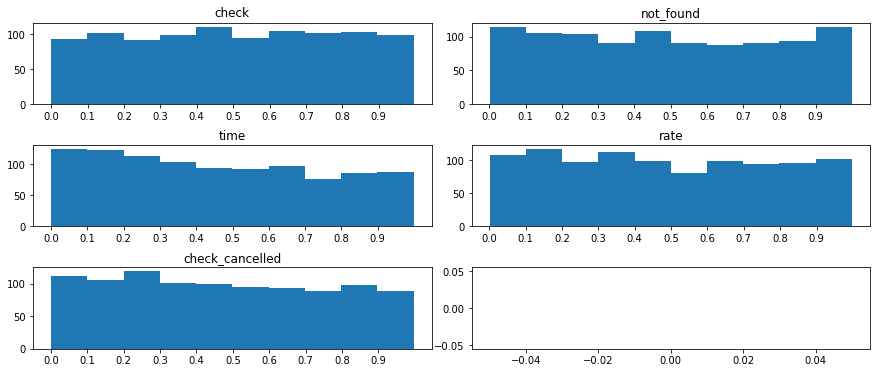

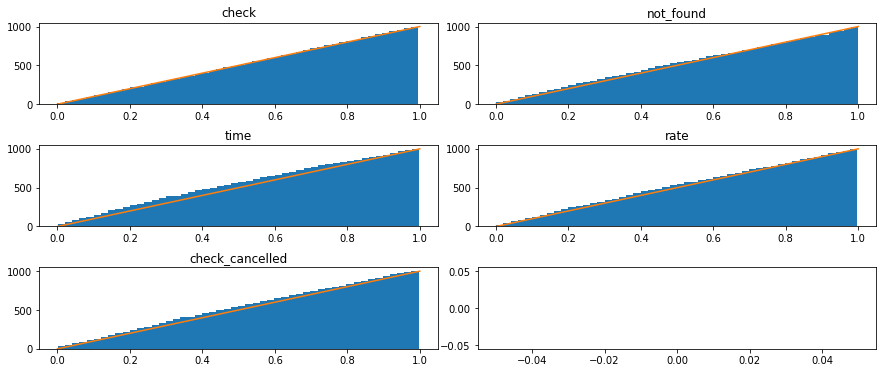

In [29]:
plot_pvals(aa_pvals_daily_smart_cuped, cumulative=True)

In [30]:
prokras(aa_pvals_daily_smart_cuped)

Metric: check. Prokras at 0.05: 0.047
Metric: check. Prokras at 0.01: 0.007

Metric: not_found. Prokras at 0.05: 0.058
Metric: not_found. Prokras at 0.01: 0.014

Metric: time. Prokras at 0.05: 0.065
Metric: time. Prokras at 0.01: 0.016

Metric: rate. Prokras at 0.05: 0.055
Metric: rate. Prokras at 0.01: 0.011

Metric: check_cancelled. Prokras at 0.05: 0.063
Metric: check_cancelled. Prokras at 0.01: 0.013



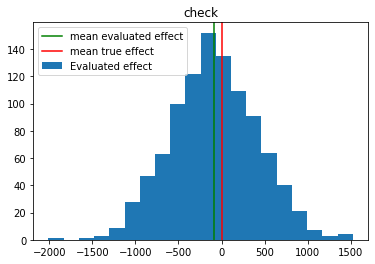

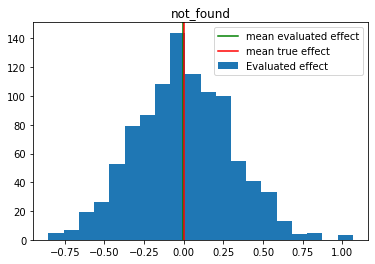

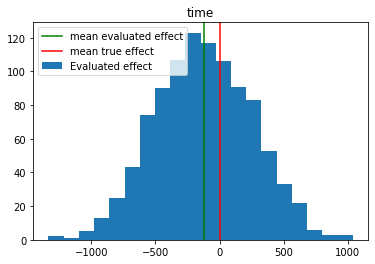

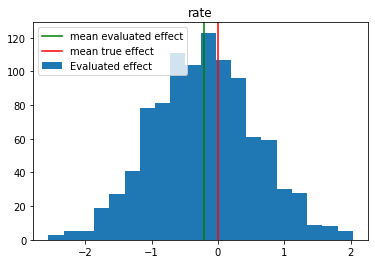

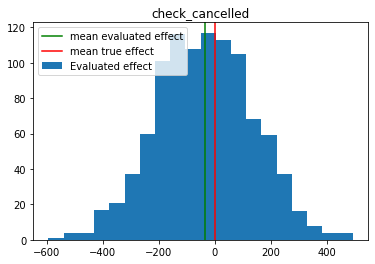

In [31]:
for metric in simple_metrics:
    plt.figure()
    plt.hist(aa_pvals_daily_smart_cuped_eff[metric], bins=20, label="Evaluated effect")
    plt.axvline(x=np.mean(aa_pvals_daily_smart_cuped_eff[metric]), color="green", label="mean evaluated effect")
    plt.axvline(x=0, color="red", label="mean true effect")
    plt.title(metric)
    plt.legend()
    plt.plot()

### A/A test on daily data on daily stratified split

In [32]:
aa_pvals_daily_smart_cuped_d = {metric: [] for metric in simple_metrics}
aa_pvals_daily_smart_cuped_d_eff = {metric: [] for metric in simple_metrics}

In [33]:
for i in tqdm(range(1000)):
    for metric in simple_metrics:
        pval, eff = simple_test_smart_cov_cuped(data_pre = df_metrics_daily_obs[metric],
                                                        data_post=df_metrics_daily_exp[metric],
                                                           metric=metric, 
                                                           test=final_split_d[i]["test"]["store_id"], 
                                                           control=final_split_d[i]["control"]["store_id"], aa_eff=True)
        aa_pvals_daily_smart_cuped_d[metric].append(pval)
        aa_pvals_daily_smart_cuped_d_eff[metric].append(eff)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [15:33<00:00,  1.07it/s]


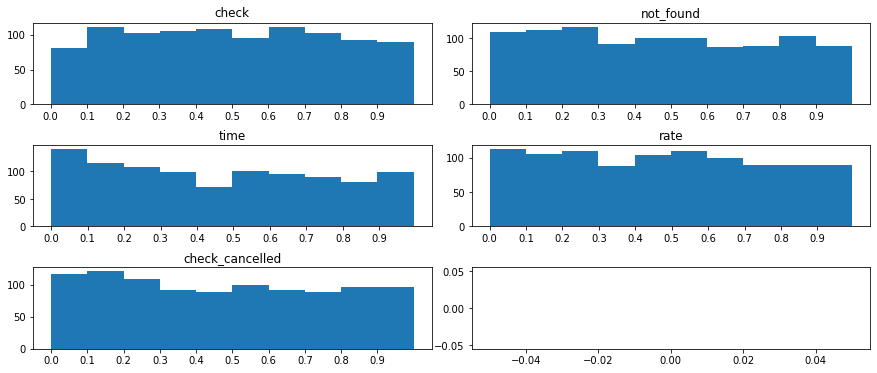

In [34]:
plot_pvals(aa_pvals_daily_smart_cuped_d)

In [35]:
prokras(aa_pvals_daily_smart_cuped_d)

Metric: check. Prokras at 0.05: 0.031
Metric: check. Prokras at 0.01: 0.005

Metric: not_found. Prokras at 0.05: 0.061
Metric: not_found. Prokras at 0.01: 0.016

Metric: time. Prokras at 0.05: 0.082
Metric: time. Prokras at 0.01: 0.016

Metric: rate. Prokras at 0.05: 0.058
Metric: rate. Prokras at 0.01: 0.011

Metric: check_cancelled. Prokras at 0.05: 0.06
Metric: check_cancelled. Prokras at 0.01: 0.012



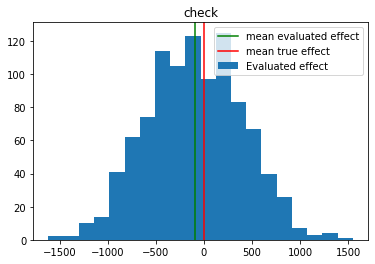

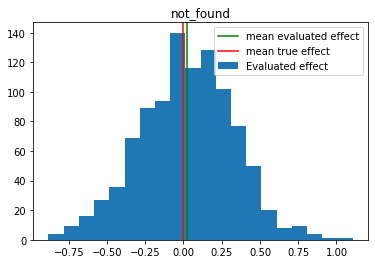

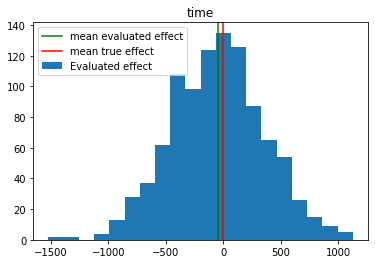

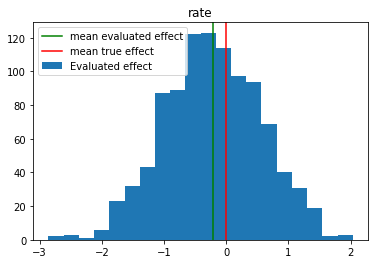

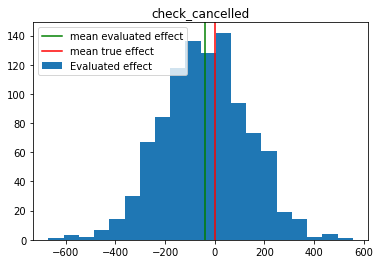

In [36]:
for metric in simple_metrics:
    plt.figure()
    plt.hist(aa_pvals_daily_smart_cuped_d_eff[metric], bins=20, label="Evaluated effect")
    plt.axvline(x=np.mean(aa_pvals_daily_smart_cuped_d_eff[metric]), color="green", label="mean evaluated effect")
    plt.axvline(x=0, color="red", label="mean true effect")
    plt.title(metric)
    plt.legend()
    plt.plot()

## SYNTHETIC AB

### Adding effect to daily metrics

### Expected effect distribution calculation

In [37]:
### Посчитаем STD и mean для наших метрик
random_splits = np.random.choice(np.arange(1000), size=100, replace=False)

In [38]:
metric_std = {metric: [] for metric in simple_metrics}
metric_mean = {metric: [] for metric in simple_metrics}

In [39]:
for split in tqdm(random_splits):
    for metric in simple_metrics:
        selected_stores = np.concatenate((final_split[split]["test"]["store_id"], final_split[split]["control"]["store_id"]))
        tmp = df_metrics_daily_obs[metric]
        tmp = tmp[tmp.store_id.isin(selected_stores)]
        metric_std[metric].append(tmp[metric].std())
        metric_mean[metric].append(tmp[metric].mean())

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 95.75it/s]


In [40]:
effect_deltas = {"not_found": 0.35, 
                 "gmv_net_of_promo": -0.01, 
                 "check": -0.01*2, 
                 "conversion": 0.05, 
                 "rate": -0.02, 
                 "time": 0.02,
                 "check_cancelled": 0.01 * 2}

In [41]:
effect_distribution = {metric: [] for metric in simple_metrics}
for metric in simple_metrics:
    effect_size = np.mean(metric_mean[metric]) * (effect_deltas[metric])
    effect_std = np.mean(metric_std[metric]) / 10
    effect_distribution[metric].append(effect_size)
    effect_distribution[metric].append(effect_std)

In [42]:
effect_distribution

{'check': [-1311.3757489401019, 18860.920007775283],
 'not_found': [9.110002347831037, 5.715078870601756],
 'time': [655.178514428241, 9476.326786755042],
 'rate': [-1.9841345708351676, 17.423443300883353],
 'check_cancelled': [133.34793445907985, 1599.8895806540554]}

### Pvals

In [43]:
ab_pvals_cuped_smart = {metric: [] for metric in simple_metrics}
ab_pvals_cuped_smart_eff = {metric: [] for metric in simple_metrics}

In [44]:
for i in tqdm(range(1000)):
    for metric in simple_metrics:
        pval, eff = simple_test_smart_cov_cuped(data_pre=df_metrics_daily_obs[metric],  data_post=df_metrics_daily_exp[metric],
                                                           metric=metric, 
                                                           test=final_split[i]["test"]["store_id"], 
                                                           control=final_split[i]["control"]["store_id"], 
                                                              synth=True, 
                                                              effect_mean=effect_distribution[metric][0],
                                                             effect_std=effect_distribution[metric][1])
        ab_pvals_cuped_smart[metric].append(pval)
        ab_pvals_cuped_smart_eff[metric].append(eff)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [15:52<00:00,  1.05it/s]


In [45]:
ab_pvals_cuped_smart_d = {metric: [] for metric in simple_metrics}
ab_pvals_cuped_smart_eff_d = {metric: [] for metric in simple_metrics}

In [46]:
for i in tqdm(range(1000)):
    for metric in simple_metrics:
        pval, eff = simple_test_smart_cov_cuped(data_pre=df_metrics_daily_obs[metric],  data_post=df_metrics_daily_exp[metric],
                                                           metric=metric, 
                                                           test=final_split_d[i]["test"]["store_id"], 
                                                           control=final_split_d[i]["control"]["store_id"], 
                                                              synth=True, 
                                                              effect_mean=effect_distribution[metric][0],
                                                             effect_std=effect_distribution[metric][1])
        ab_pvals_cuped_smart_d[metric].append(pval)
        ab_pvals_cuped_smart_eff_d[metric].append(eff)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [15:35<00:00,  1.07it/s]


### Plots

In [47]:
### basic strat split

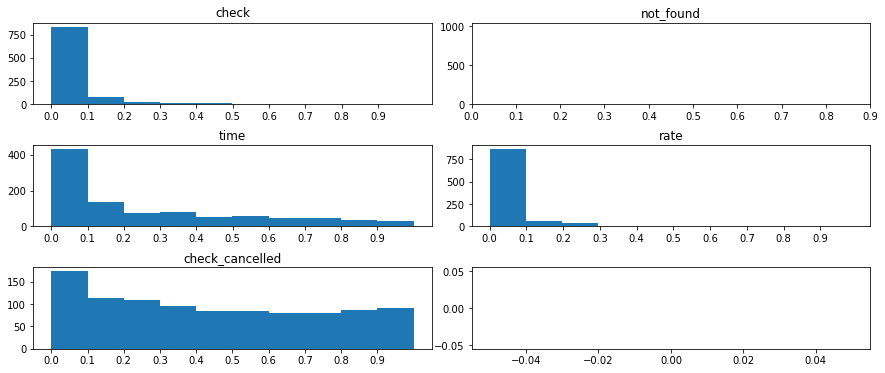

In [48]:
plot_pvals(ab_pvals_cuped_smart)

In [49]:
prokras(ab_pvals_cuped_smart)

Metric: check. Prokras at 0.05: 0.751
Metric: check. Prokras at 0.01: 0.517

Metric: not_found. Prokras at 0.05: 1.0
Metric: not_found. Prokras at 0.01: 1.0

Metric: time. Prokras at 0.05: 0.311
Metric: time. Prokras at 0.01: 0.149

Metric: rate. Prokras at 0.05: 0.799
Metric: rate. Prokras at 0.01: 0.593

Metric: check_cancelled. Prokras at 0.05: 0.095
Metric: check_cancelled. Prokras at 0.01: 0.022



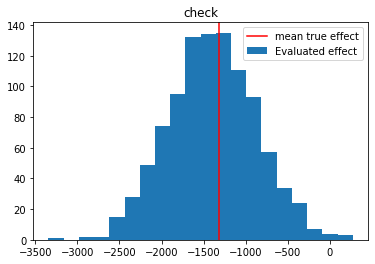

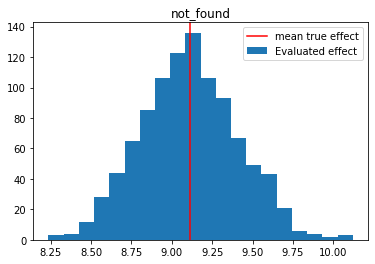

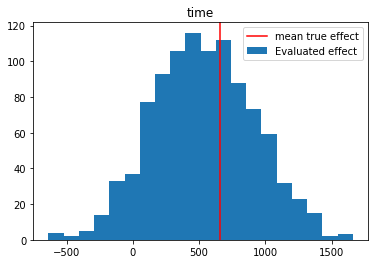

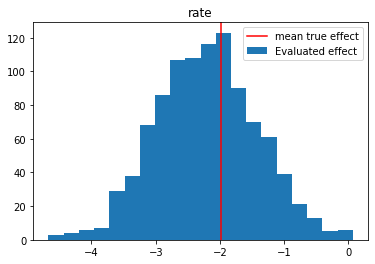

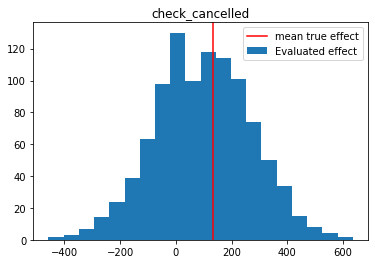

In [50]:
for metric in simple_metrics:
    plt.figure()
    plt.hist(ab_pvals_cuped_smart_eff[metric], bins=20, label="Evaluated effect")
    plt.axvline(x=effect_distribution[metric][0], color="red", label="mean true effect")
    plt.title(metric)
    plt.legend()
    plt.plot()

In [51]:
### daily mean strat split

In [52]:
prokras(ab_pvals_cuped_smart_d)

Metric: check. Prokras at 0.05: 0.748
Metric: check. Prokras at 0.01: 0.517

Metric: not_found. Prokras at 0.05: 1.0
Metric: not_found. Prokras at 0.01: 1.0

Metric: time. Prokras at 0.05: 0.391
Metric: time. Prokras at 0.01: 0.203

Metric: rate. Prokras at 0.05: 0.803
Metric: rate. Prokras at 0.01: 0.593

Metric: check_cancelled. Prokras at 0.05: 0.105
Metric: check_cancelled. Prokras at 0.01: 0.025



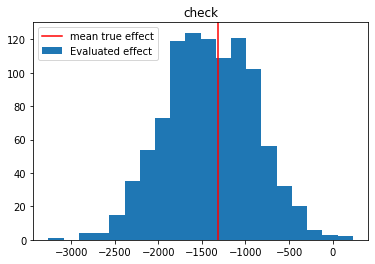

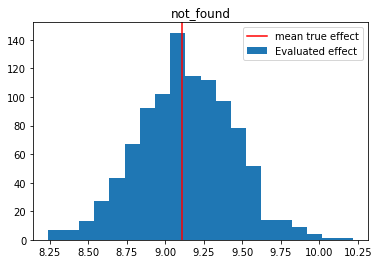

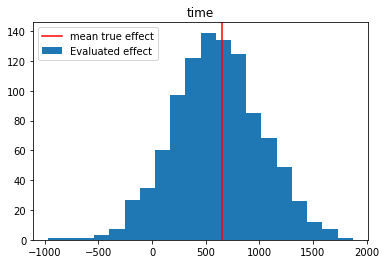

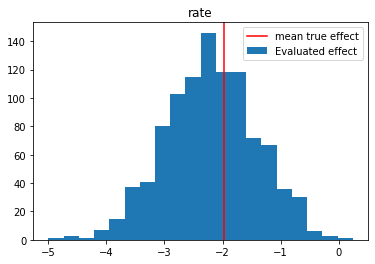

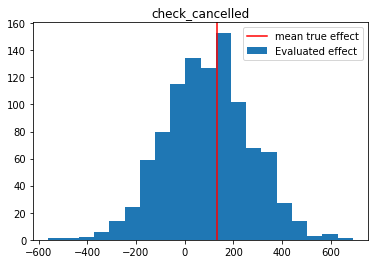

In [53]:
for metric in simple_metrics:
    plt.figure()
    plt.hist(ab_pvals_cuped_smart_eff_d[metric], bins=20, label="Evaluated effect")
    plt.axvline(x=effect_distribution[metric][0], color="red", label="mean true effect")
    plt.title(metric)
    plt.legend()
    plt.plot()